### Here we are going to create a small neural network that predicts the output of a function. 

In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt 
from matplotlib import animation
from IPython.display import HTML

<font size=4>
We will need two main things to train our first neural network. Training data and a (nn) model.
Let's make the data first. This will be pairs of inputs and outputs, that are related by some function (which the NN will try to learn). Here, I'm just going to choose some random polynomial as the function.
</font>

<font size=4>
We'll start with a 1-dimensional input
</font>

In [2]:
N_samples = 10_000

inputs = torch.rand(10_000, 1) - 0.5 # random values between -1/2 and 1/2
inputs = inputs*2 # now random values between -2 and 2

print("inputs shape", inputs.shape)

def f(x): return 16*x**5 - 20*x**3 + 5*x # this is the "correct" function that will generate our input/output data pairs. This is a Chebychev polynomial that I chose at random.

outputs = f(inputs)
print("outputs shape", outputs.shape)

inputs shape torch.Size([10000, 1])
outputs shape torch.Size([10000, 1])


<font size=4>
This data is very clean. In real life, there will generally be some noise on our true data. We can model this by adding a bit of gaussian noise to each output point.
</font>

In [3]:
outputs_noisy = f(inputs) + torch.randn_like(inputs)*0.1 # noise amplitude is 0.1


Text(0.5, 1.0, 'Slightly noisy data')

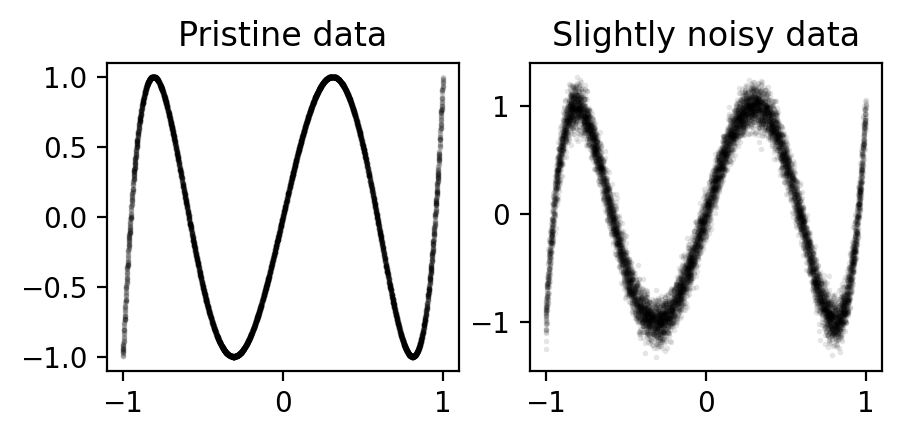

In [4]:
fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)

ax[0].scatter(inputs, outputs, s=4, color='k', alpha=0.1, lw=0)
ax[1].scatter(inputs, outputs_noisy, s=4, color='k', alpha=0.1, lw=0)

ax[0].set_title("Pristine data")
ax[1].set_title("Slightly noisy data")

# Neural networks

<font size=4>
Neural networks are essentially big functions that are characterized by a bunch of <b>parameters</b>.

Here I will demonstrate two different ways to make a network that will make predictions. 

1) Using a good guess of the true functional form.
2) Using a generic neural network (next notebook).

Before actually using the full NN machinery of pytorch, I will show how we can write the training "by hand".
</font>

In [5]:
parameters = torch.tensor([1.0, 1.0, 1.0])

def f_nn(x): # this is our "NN", which will produce a guess of the true output, given some input x.
    return parameters[0]*x**5 + parameters[1]*x**3 + parameters[2]*x 

(-2.0, 2.0)

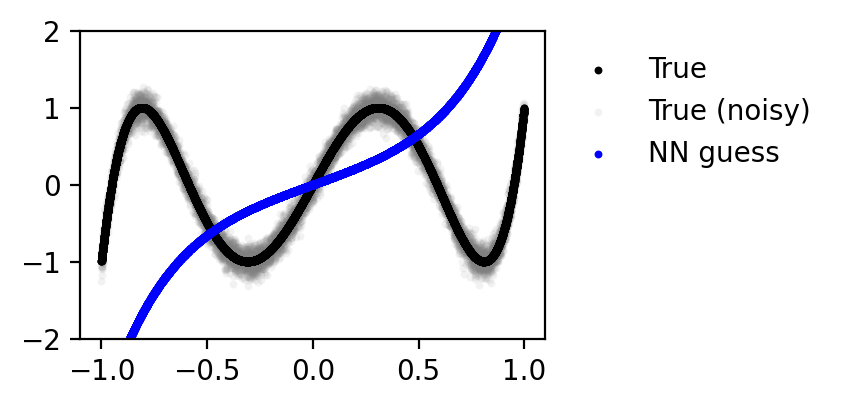

In [6]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, f_nn(inputs), s=8, color='b', alpha=1, lw=0, label='NN guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)
ax.set_ylim(-2,2)

<font size=4>
Clearly our guess of parameters (of 1, 1, 1) is not very good (the true parameters are 16, -20, and 5). 

How do we measure how bad our parameters are? In general, since we don't know the true parameters, we minimize the deviation of the observed outputs from the predicted oubputs:
</font>
$$ \min \sum_i (f^{(pred)}(x_i) - f^{(obs)}_i)^2$$

<font size=4>
This tells us how bad our predictions are over the whole dataset, where we take the sum of differences over all samples $i$. 

This function is also called a <b>loss function</b>.
</font>
$$ \mathcal{L} = \sum_i (f^{(pred)}(x_i) - f^{(obs)}_i)^2$$

In [7]:
loss = torch.sum((f_nn(inputs) - outputs)**2)
print(loss)

tensor(24075.4453)


# Loss functions and minimization

<font size=4>
The central goal of machine learning is to find the parameters which minimize this function. To do so, we do gradient descent (or variants thereof).

To illustrate this, consider an even simpler example.
</font>

In [8]:
x_simple = torch.tensor([1.]) # a single data point
true_param = 0.5 # the function will depend on a single parameter
f_simple = ((x_simple - true_param)**2 - 1)**2 - 0.2*true_param**3  # a single observation

nn_parameter = torch.tensor([0.01]) # our guess of the true parameter
def f_nn_simple(x): return ((x - nn_parameter)**2 - 1)**2 - 0.2*nn_parameter**3 # there is one parameter that we will try to find

<font size=4>
Let's visualize the loss function for many different choices of the parameter.
</font>

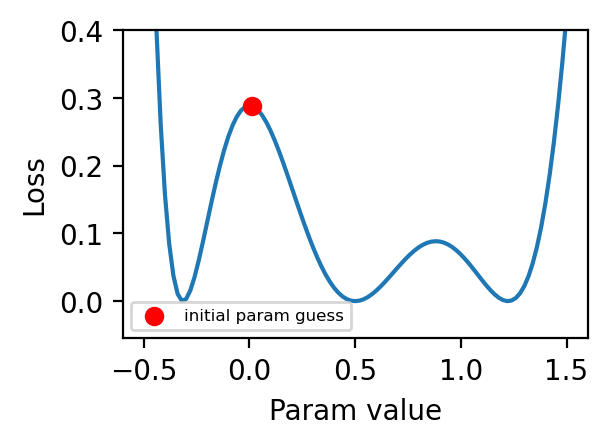

In [9]:
param_sweep = torch.linspace(-0.5, 1.5, 101)

# this is the value of the function that we get if we choose different parameters
f_guesses = [((x_simple - p)**2 - 1)**2 - 0.2*p**3 for p in param_sweep]
f_guesses = torch.tensor(f_guesses)

loss = (f_simple - f_guesses)**2

fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)
ax.plot(param_sweep, loss)

loss_at_initial_guess = (f_nn_simple(x_simple) - f_simple)**2
ax.scatter(nn_parameter.detach(), loss_at_initial_guess.detach(), color='red', zorder=10, label='initial param guess')

ax.set_ylim(None, 0.4)
ax.set_xlabel('Param value')
ax.set_ylabel('Loss')
ax.legend(fontsize=6)

<font size=4>
Gradient descent will go "down" the hils of the loss function. A step "down" the hill is given by the gradient of the function
</font> 
$$ \text{step} = -\frac{\partial \mathcal{L}}{\partial p}$$
<font size=4>
So we will update our parameter value with small steps in this direction. In going from iteration t to t+1, we will do
</font> 
$$ p_{t+1} = p_t + \text{step size}\times \text{step} $$
<font size=4>
Where "step size" is some small parameter, typically called the learning rate, that defines how fast we go down the hill. In equations,
</font> 
$$ p_{t+1} = p_t - \eta \frac{\partial \mathcal{L}}{\partial p} $$

<font size=4>

This is great, if only we could calculate the derivatives! This is exactly what pytorch is optimized to do. To do this, we will first have to tell torch that we will want to keep track of the fuctions's derivatives (gradients) with respect to the parameter. We do this by changing the "requires grad" function.
</font> 

In [10]:
nn_parameter.requires_grad = True # torch will now keep track of gradients

loss = (f_nn_simple(x_simple) - f_simple)**2

loss.backward() # this is where the gradients are actually calculated

<font size=4>
By calling loss.backward(), we computed the gradients of the loss w.r.t the parameter, which is now stored in the "grad" attribute of the parameter:
</font> 

In [11]:
nn_parameter.grad

tensor([-0.0846])

<font size=4>
We can now take a small step in the direction of the gradient and see if the loss actually decreases.
</font> 

In [12]:
step_size = 0.01

nn_parameter = nn_parameter - step_size*nn_parameter.grad.detach()

nn_parameter.grad = None

loss_new = (f_nn_simple(x_simple) - f_simple)**2

print("Difference in losses (should be <0!) ", loss_new.detach() - loss.detach())

Difference in losses (should be <0!)  tensor([-7.4536e-05])


<font size=4>
Now let's do many such steps to see if we approach the minimum
</font> 

In [13]:
step_size = 0.05

parameter_history = []
loss_history = []

nn_parameter = torch.tensor([0.01]) # initial guess
for step in range(100):
    parameter_history.append(nn_parameter.clone().detach())

    nn_parameter.requires_grad = True
    nn_parameter.grad = None

    loss = (f_nn_simple(x_simple) - f_simple)**2
    loss.backward() # calculate gradient

    loss_history.append(loss.detach())
    
    nn_parameter = nn_parameter.clone().detach() - step_size*nn_parameter.grad.detach() # update!

print("Difference in losses (should be <0!) ", loss_new.detach() - loss.detach())

Difference in losses (should be <0!)  tensor([0.2884])


Text(0, 0.5, 'Loss')

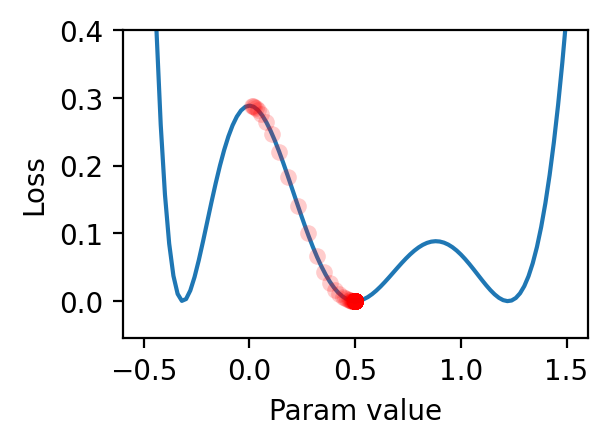

In [14]:
param_sweep = torch.linspace(-0.5, 1.5, 101)

# this is the value of the function that we get if we choose different parameters
f_guesses = [((x_simple - p)**2 - 1)**2 - 0.2*p**3 for p in param_sweep]
f_guesses = torch.tensor(f_guesses)

loss = (f_simple - f_guesses)**2

fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)
ax.plot(param_sweep, loss)

ax.scatter(parameter_history, loss_history, color='red', zorder=10, lw=0, alpha=0.2)

ax.set_ylim(None, 0.4)
ax.set_xlabel('Param value')
ax.set_ylabel('Loss')

In [15]:
def plot_evolving_loss(param_vals, loss_vals, lineclr = 'k', linealpha=0.99, interval=20):
    def init():
        scat.set_offsets([[param_vals[0], loss_vals[0]]]) # takes Nx2 array

        return scat,
    
    def animate(i):
        scat.set_offsets([[param_vals[i], loss_vals[i]]]) # takes Nx2 array

        ax.set_title(f'Loss = {loss_vals[i].detach().squeeze():0.2f}')
    
        return scat,

    param_sweep = torch.linspace(-0.5, 1.5, 101)

    # this is the value of the function that we get if we choose different parameters
    f_guesses = [((x_simple - p)**2 - 1)**2 - 0.2*p**3 for p in param_sweep]
    f_guesses = torch.tensor(f_guesses)
    
    loss = (f_simple - f_guesses)**2
    
    fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)
    ax.plot(param_sweep, loss, color='gray')
    
    scat = ax.scatter([param_vals[0]], [loss_vals[0]], color='red', zorder=10, lw=0, alpha=0.8)
    
    ax.set_ylim(None, 0.4)
    ax.set_xlabel('Param value')
    ax.set_ylabel('Loss')
    
    plt.close();
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(param_vals), interval=interval, blit=True)
    return anim


In [16]:
HTML(plot_evolving_loss(parameter_history, loss_history, interval=20, lineclr='k', linealpha=0.1).to_html5_video())

# Gradient descent applied to our data

In [17]:
# Recall the names of things from an above cell:

# parameters = torch.tensor([1.0, 1.0, 1.0])
# def f_nn(x): return parameters[0]*x**5 + parameters[1]*x**3 + parameters[2]*x 

In [18]:
step_size = 0.0001

parameter_history = []
loss_history = []

parameters = torch.tensor([1.0, 1.0, 1.0]) # initial guess
for step in range(3000):
    parameter_history.append(parameters.clone().detach())

    parameters.requires_grad = True
    parameters.grad = None

    loss = torch.sum((f_nn(inputs) - outputs)**2) # sum over all samples
    loss.backward() # calculate gradient

    loss_history.append(loss.detach())
    
    parameters = parameters.clone().detach() - step_size*parameters.grad.detach() # update! 
    # Note that we clone and detach the parameters, otherwise pytorch will keep track of all the previous gradients as well, which we don't want.

print("Difference in losses (should be <0!) ", loss_new.detach() - loss.detach())

Difference in losses (should be <0!)  tensor([-1.7322])


In [19]:
print(parameters)

tensor([ 15.6371, -19.5820,   4.9044])


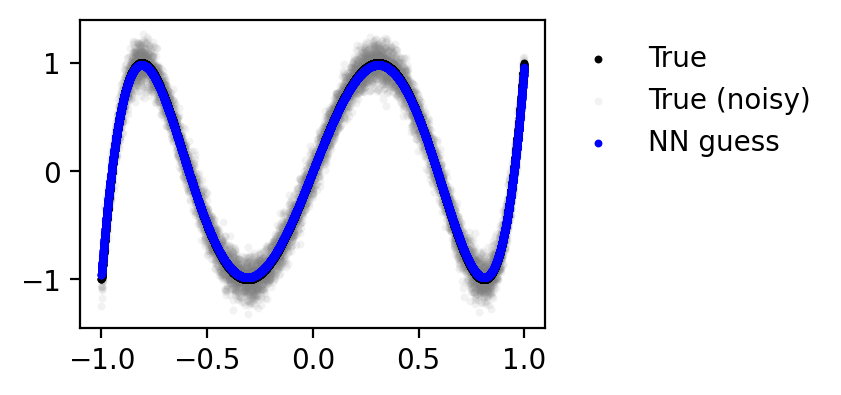

In [20]:
fig,ax=plt.subplots(1,1,figsize=(3,2),dpi=200)

ax.scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
ax.scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
ax.scatter(inputs, f_nn(inputs), s=8, color='b', alpha=1, lw=0, label='NN guess')

ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

In [21]:
#np.asarray(parameter_history).shape
#f_nn_param_arg(inputs, parameter_history[-1].squeeze()).shape
inputs.shape

torch.Size([10000, 1])

In [22]:
def f_nn_param_arg(x, p): # helper function that I can pass the parameters to as an argument
    return p[0]*x**5 + p[1]*x**3 + p[2]*x 
    
def plot_evolving_loss_and_curve(param_vals, loss_vals, lineclr = 'k', linealpha=0.99, interval=20):
    def init():
        scat.set_offsets(np.asarray([inputs.squeeze(), f_nn_param_arg(inputs, param_vals[0]).squeeze()]).T) # takes Nx2 array
        line.set_data([[0], [loss_vals[0]]])

        return (scat, line)
    
    def animate(i):
        scat.set_offsets(np.asarray([inputs.squeeze(), f_nn_param_arg(inputs, param_vals[i]).squeeze()]).T)
        line.set_data([np.arange(i), loss_vals[:i]])

        ax[0].set_title(f'Loss = {loss_vals[i].detach().squeeze():0.2f}')
    
        return (scat, line)

    
    
    fig,ax=plt.subplots(1,2,figsize=(5,2),dpi=200)
    
    ax[0].scatter(inputs, outputs, s=8, color='k', alpha=1, lw=0, label='True')
    ax[0].scatter(inputs, outputs_noisy, s=8, color='gray', alpha=0.1, lw=0, label='True (noisy)', zorder=-1)
    scat = ax[0].scatter(inputs, f_nn(inputs), s=8, color='b', alpha=1, lw=0, label='NN guess')
    
    line, = ax[1].plot([0], [loss_vals[0]], color='r')
    
    ax[1].set_xlim(0, len(loss_vals))
    ax[1].set_ylim(np.min(loss_vals), np.max(loss_vals))
    ax[1].set_yscale('log')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('N Steps')
    
    plt.close();
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(param_vals), interval=interval, blit=True)
    return anim


In [23]:
HTML(plot_evolving_loss_and_curve(parameter_history[::20], loss_history[::20], interval=20, lineclr='k', linealpha=0.1).to_html5_video())

# THINGS FOR YOU TO TRY!
1) How does the learning go for different values of initial conditions, step size, or total number of steps?
2) In the simple 1D example, verify that the gradients are correct by comparing the computed gradient values to the true gradients (which you can compute by hand)
3) In the 1D example, how does the learned function depend on initial condition?

# Summary and some notes

Useful methods

- `A.requires_grad`: require that a certain variable/parameter requires gradients
- `A.grad`: this stores the gradient of the variable `A`. If you A requires grad but you haven't yet computed the gradients, this will be `None`
- `loss.backward()`: This is where the actual gradients are computed. If the loss function depends in any way on `A`, then this will populate `A.grad` with `A.grad = `$\frac{\partial \text{loss}}{\partial \text{A}}$
- `A.clone()`: Makes a copy of `A`, including any grads
- `A.detach()`: Detaches `A` from the grad computation graph. This will clear gradients and make it so that if you do loss.backward() again, the grad of A won't be computed.

Reference tutorial for torch autograd (used under the hood to compute gradients)
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html